Importing the libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

Reading the data

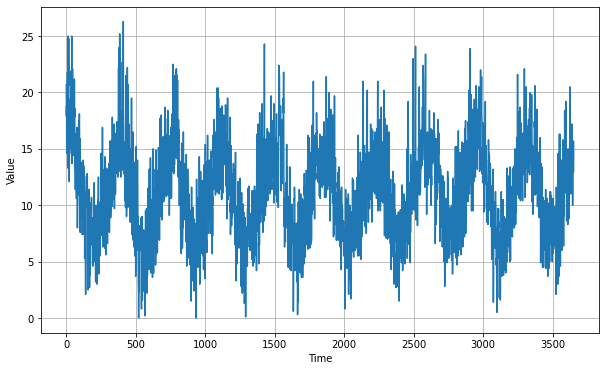

In [4]:
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temps.append(float(row[1]))



series = np.array(temps)
time = np.array(range(1,len(series)+1))
plt.figure(figsize=(10, 6))
plot_series(time, series)

Spliiting the data into training and validation set

In [5]:
split_time = 2500
time_train =time[:split_time]
x_train =series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)



<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


Defining the model

In [9]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
10/10 [==============================] - 17s 2s/step - loss: 31.1551 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 6s 618ms/step - loss: 30.5849 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 6s 611ms/step - loss: 29.6259 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 6s 586ms/step - loss: 28.5432 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 6s 590ms/step - loss: 27.2554 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 6s 595ms/step - loss: 25.4769 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 6s 593ms/step - loss: 23.3469 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 6s 587ms/step - loss: 20.5459 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 6s 579ms/step - loss: 17.2022 - mae: 17.8083
Epoch 10/100
10/10 [==============================] - 6s 586ms/step - loss: 13.5213 - mae: 14.1192
Epoch 11/100
10/10 [=

10/10 [==============================] - 6s 574ms/step - loss: 5.7356 - mae: 6.2602
Epoch 86/100
10/10 [==============================] - 6s 577ms/step - loss: 6.2117 - mae: 6.7696
Epoch 87/100
10/10 [==============================] - 6s 588ms/step - loss: 7.0577 - mae: 6.8628
Epoch 88/100
10/10 [==============================] - 6s 588ms/step - loss: 46.8818 - mae: 44.6237
Epoch 89/100
10/10 [==============================] - 6s 579ms/step - loss: 36.3917 - mae: 36.7981
Epoch 90/100
10/10 [==============================] - 6s 584ms/step - loss: 40.8447 - mae: 40.2180
Epoch 91/100
10/10 [==============================] - 6s 585ms/step - loss: 26.2658 - mae: 26.5330
Epoch 92/100
10/10 [==============================] - 6s 598ms/step - loss: 29.3248 - mae: 29.3853
Epoch 93/100
10/10 [==============================] - 6s 591ms/step - loss: 32.8947 - mae: 33.7466
Epoch 94/100
10/10 [==============================] - 6s 586ms/step - loss: 36.8493 - mae: 36.6766
Epoch 95/100
10/10 [=========

(1e-08, 0.0001, 0.0, 60.0)

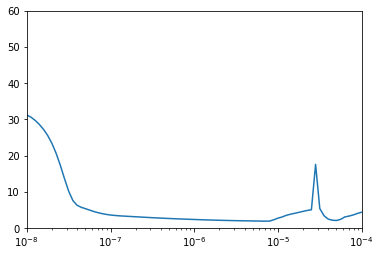

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=250)

Epoch 1/250
25/25 [==============================] - 13s 525ms/step - loss: 6.1736 - mae: 6.6993
Epoch 2/250
25/25 [==============================] - 5s 209ms/step - loss: 2.9776 - mae: 3.4619
Epoch 3/250
25/25 [==============================] - 5s 200ms/step - loss: 2.1727 - mae: 2.6332
Epoch 4/250
25/25 [==============================] - 5s 201ms/step - loss: 1.9502 - mae: 2.4055
Epoch 5/250
25/25 [==============================] - 5s 208ms/step - loss: 1.8199 - mae: 2.2746 4s - loss: 1.
Epoch 6/250
25/25 [==============================] - 6s 227ms/step - loss: 1.7427 - mae: 2.1950 0s - loss: 1.7487 - mae: 2.2
Epoch 7/250
25/25 [==============================] - 6s 223ms/step - loss: 1.6968 - mae: 2.1474
Epoch 8/250
25/25 [==============================] - 5s 211ms/step - loss: 1.6691 - mae: 2.1180
Epoch 9/250
25/25 [==============================] - 5s 207ms/step - loss: 1.6535 - mae: 2.1035 5s - loss: 
Epoch 10/250
25/25 [==============================] - 5s 209ms/step - loss: 1.64

25/25 [==============================] - 5s 215ms/step - loss: 1.4955 - mae: 1.9381
Epoch 84/250
25/25 [==============================] - 5s 201ms/step - loss: 1.4949 - mae: 1.9362
Epoch 85/250
25/25 [==============================] - 5s 191ms/step - loss: 1.4918 - mae: 1.9342
Epoch 86/250
25/25 [==============================] - 5s 190ms/step - loss: 1.4915 - mae: 1.9342
Epoch 87/250
25/25 [==============================] - 5s 189ms/step - loss: 1.4943 - mae: 1.9356
Epoch 88/250
25/25 [==============================] - 5s 193ms/step - loss: 1.4955 - mae: 1.9368
Epoch 89/250
25/25 [==============================] - 5s 191ms/step - loss: 1.4911 - mae: 1.9342
Epoch 90/250
25/25 [==============================] - 5s 190ms/step - loss: 1.4926 - mae: 1.9335
Epoch 91/250
25/25 [==============================] - 5s 191ms/step - loss: 1.4903 - mae: 1.9324
Epoch 92/250
25/25 [==============================] - 5s 192ms/step - loss: 1.4903 - mae: 1.9323
Epoch 93/250
25/25 [=======================

25/25 [==============================] - 5s 187ms/step - loss: 1.4698 - mae: 1.9101
Epoch 165/250
25/25 [==============================] - 5s 190ms/step - loss: 1.4763 - mae: 1.9180
Epoch 166/250
25/25 [==============================] - 5s 190ms/step - loss: 1.4729 - mae: 1.9104 0s - loss: 1.4699 - mae: 1.909
Epoch 167/250
25/25 [==============================] - 5s 191ms/step - loss: 1.4697 - mae: 1.9099
Epoch 168/250
25/25 [==============================] - 5s 192ms/step - loss: 1.4725 - mae: 1.9122
Epoch 169/250
25/25 [==============================] - 5s 187ms/step - loss: 1.4708 - mae: 1.9115
Epoch 170/250
25/25 [==============================] - 5s 189ms/step - loss: 1.4698 - mae: 1.9087
Epoch 171/250
25/25 [==============================] - 5s 189ms/step - loss: 1.4736 - mae: 1.9133
Epoch 172/250
25/25 [==============================] - 5s 191ms/step - loss: 1.4717 - mae: 1.9114
Epoch 173/250
25/25 [==============================] - 5s 190ms/step - loss: 1.4681 - mae: 1.9081 4s 

25/25 [==============================] - 6s 222ms/step - loss: 1.4637 - mae: 1.9028
Epoch 247/250
25/25 [==============================] - 6s 237ms/step - loss: 1.4597 - mae: 1.8983 3s - loss: 1.4783 - 
Epoch 248/250
25/25 [==============================] - 5s 211ms/step - loss: 1.4582 - mae: 1.8986
Epoch 249/250
25/25 [==============================] - 7s 262ms/step - loss: 1.4715 - mae: 1.9105
Epoch 250/250
25/25 [==============================] - 7s 263ms/step - loss: 1.4630 - mae: 1.9039


Forecasting

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

Visualizing the outcome

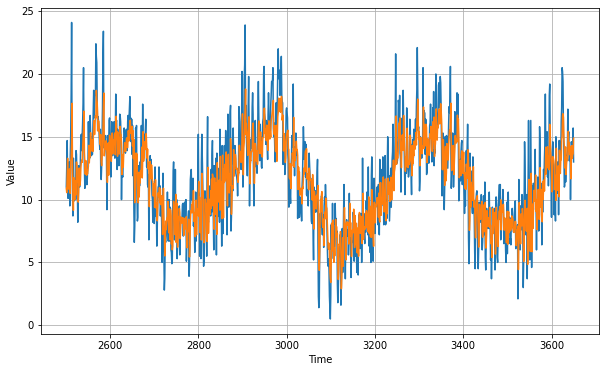

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Analyse the accuracy

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7931072

In [15]:
print(rnn_forecast)

[10.881504 10.556271 11.99358  ... 13.556674 13.656145 14.886734]
